Dataset loaded: 575 samples, each with shape (112, 92, 1)
Dataset Split:
Training set: 401 samples
Validation set: 87 samples
Test set: 87 samples


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.0654 - loss: 3.0464 - val_accuracy: 0.1954 - val_loss: 2.9167
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1576 - loss: 2.8784 - val_accuracy: 0.2759 - val_loss: 2.6599
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2609 - loss: 2.5702 - val_accuracy: 0.4368 - val_loss: 1.9947
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3941 - loss: 1.9550 - val_accuracy: 0.6322 - val_loss: 1.3923
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5618 - loss: 1.4835 - val_accuracy: 0.8161 - val_loss: 0.9661
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6397 - loss: 1.1818 - val_accuracy: 0.8161 - val_loss: 0.7882
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7092 - loss: 0.9333 - val_accuracy: 0.9080 - val_loss: 0.4648
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7808 - loss: 0.7443 - val_accuracy: 0.9195 -

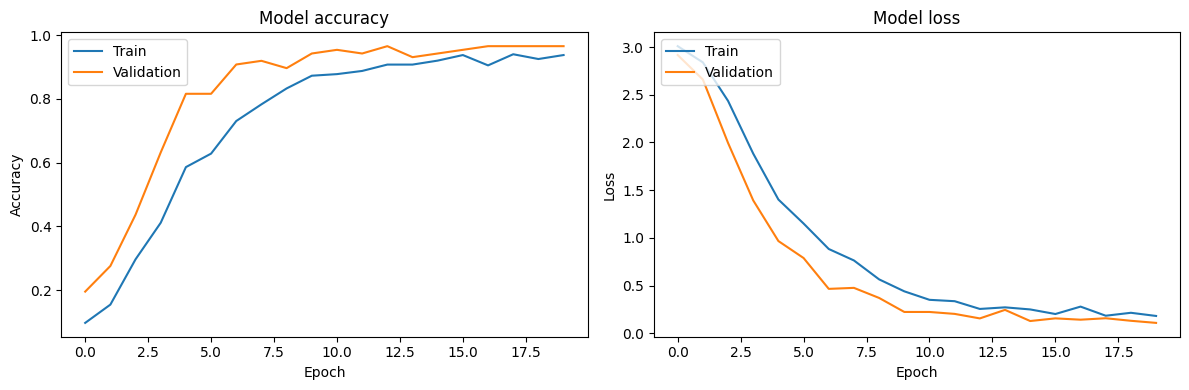

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


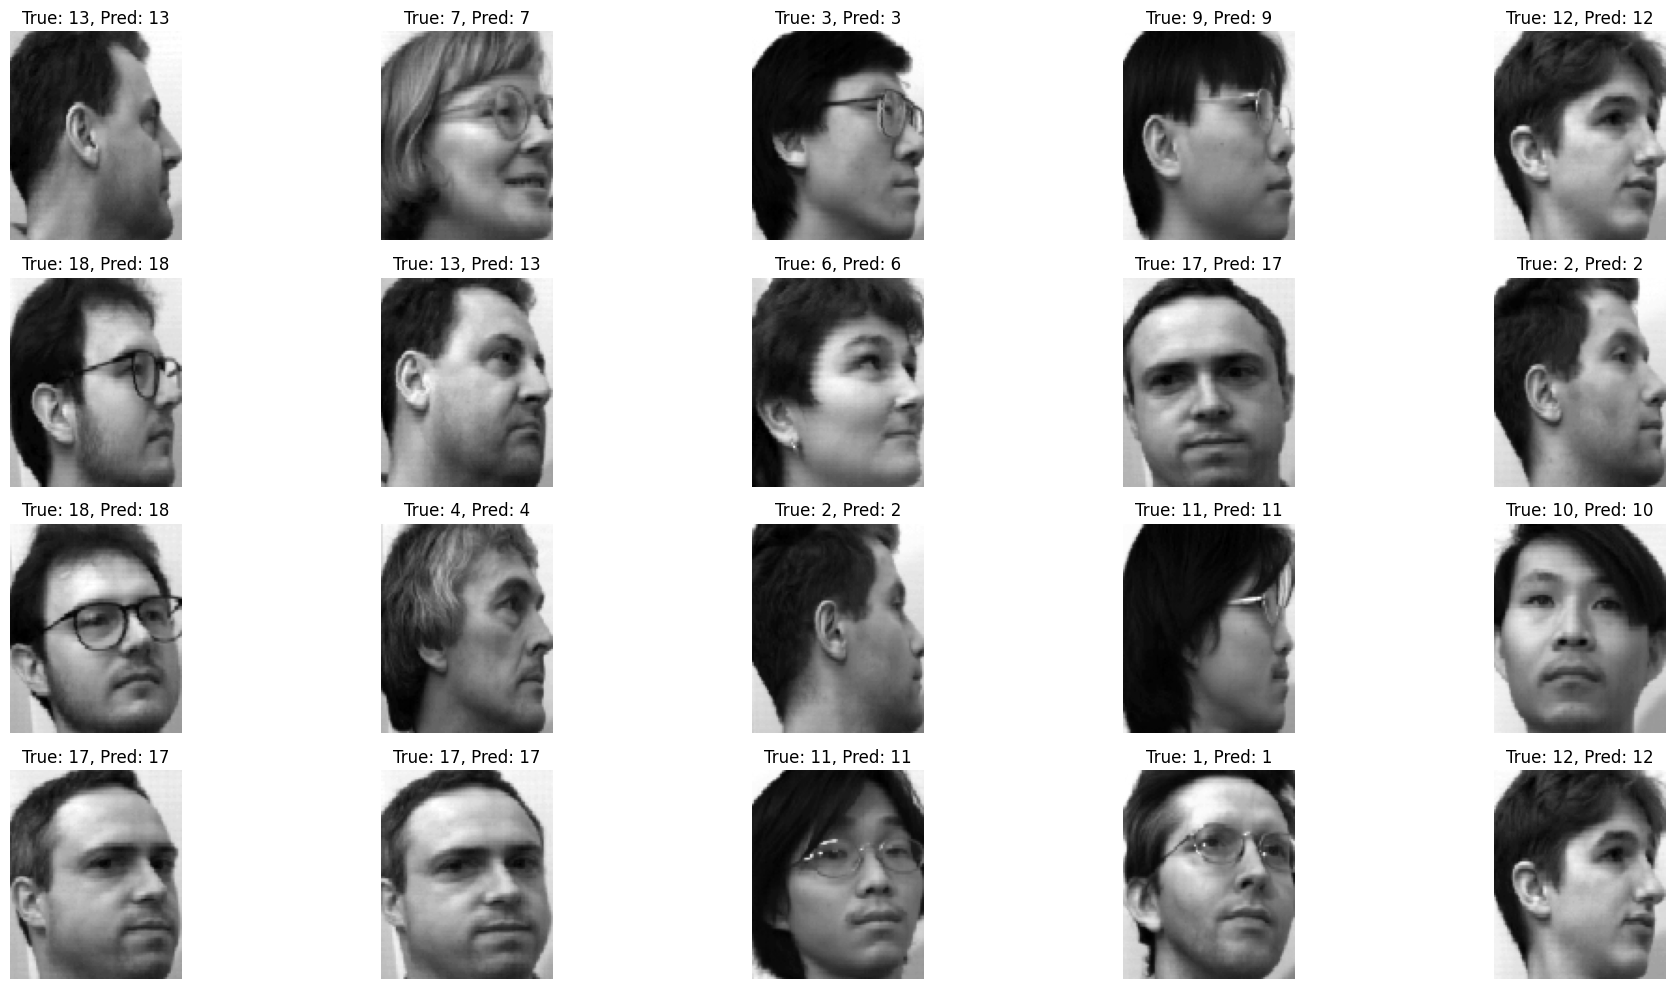

In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Load the file
file_path = '/content/drive/MyDrive/umist_cropped.mat'  # Path to the uploaded file
data = scipy.io.loadmat(file_path)

# Extracting image data and labels
facedat = data['facedat']  # Image data for each class
dirnames = data['dirnames']  # Class identifiers

# Flatten the dataset into a usable format
images = []  # To store images
labels = []  # To store corresponding class labels

# Looping through each class in facedat and extract the images
for class_index, class_data in enumerate(facedat[0]):
    num_images = class_data.shape[-1]  # Number of images in the class
    for i in range(num_images):
        images.append(class_data[:, :, i])  # Append each image
        labels.append(class_index)  # Assign the class index as the label

# Converting lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape images to have a single channel
images = images[..., np.newaxis]

print(f"Dataset loaded: {images.shape[0]} samples, each with shape {images.shape[1:]}")

# Dataset Splitting
# Split the data into training, validation, and test sets with stratified sampling
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.15, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42
)  # 0.1765 ensures ~15% validation

print("Dataset Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize pixel values to [0, 1]
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_norm.shape[1:])),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=20, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predict on test set
y_pred = np.argmax(model.predict(X_test_norm), axis=-1)

# Visualize some predictions
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test_norm[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 110, 90, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 53, 43, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 26, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 34944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,472,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,483,070 (51.43 MB)

 Trainable params: 4,494,356 (17.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,988,714 (34.29 MB)